In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from math import nan

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as mymaps
from matplotlib.patches import Rectangle
from matplotlib.colors import BoundaryNorm

import warnings
warnings.filterwarnings('ignore')

import sys
from qtrendutils import colormap_utils as mycolors
from qtrendutils import averaging_utils as avg
from qtrendutils import colorbar_utils as cbars
from qtrendutils import calendar_utils as cal
from qtrendutils import binplot_utils as binplot

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/"
trendpath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/"

### Land Fraction

In [3]:
landfrac = xr.open_dataset("../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

### Calculate the Aridity Index from TerraClim regridded onto the CESM grid

In [4]:
ppt = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PPT_Terraclim_1980_2020.nc")
ppt = ppt.sel(time=slice("1980-01-01","2020-12-31"))
pet = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PET_Terraclim_1980_2020.nc")
pet = pet.sel(time=slice("1980-01-01","2020-12-31"))

ppt = ppt.mean('time')
pet = pet.mean('time')
aridity = ppt.ppt/pet.pet
aridity['lon'] = landfrac.lon ; aridity['lat'] = landfrac.lat

aridmask = landfrac.where( (aridity > 0.05) & (aridity < 0.5), nan)
humidmask = landfrac.where( (aridity >= 0.5), nan)
hyperaridmask = landfrac.where( (aridity <= 0.05), nan)

#---omitting Antarctica
aridmask = aridmask.where( aridmask.lat > -70, nan)
humidmask = humidmask.where( humidmask.lat > -70, nan)
hyperaridmask = hyperaridmask.where(hyperaridmask.lat > -70, nan)

### Read in the observational map data

In [5]:
#----ISD
isddat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")

# drop stations that have more than 48 months with less than 15 bad days
dropstations=[]
for istation in np.arange(0,isddat.station.size,1):
    test = isddat.nbaddays.isel(station=istation)
    test = test.where( test > 15, drop=True)
    if (test.size > 48):
        badstation = np.array_str(isddat.station.isel(station=istation).values)
        dropstations.append(badstation)
isddat = isddat.drop_sel(station=dropstations)

# drop the lons and lats for now
lons = isddat.lons ; lats = isddat.lats
isddat = isddat.drop_vars(['lons','lats'])

# compute the seasonal cycle
isd_seascyc = isddat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_deseas = isddat.groupby('time.month') - isd_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
isd_seascyc = isd_seascyc.rename({"month":"time"})
isd_seascyc['time'] = isddat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_seascyc_am = cal.calcannualmean(isd_seascyc)

# annual average of seasonalized anomalies
isd_deseas_am = cal.calcannualmean(isd_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_seascyc_am = isd_seascyc_am.expand_dims({"otheryrs":isd_deseas_am.year.size})
isd_seascyc_am = isd_seascyc_am.stack(z=("year","otheryrs"))
isd_seascyc_am = isd_seascyc_am.reset_index('z', drop=True).rename(z="year")
isd_seascyc_am = isd_seascyc_am.assign_coords({'year':isd_deseas_am.year})

# add back in the annual average climatology
isd_am = isd_seascyc_am + isd_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
isdmap = xr.apply_ufunc(linfit.compute_slope, isd_am, vectorize=True, input_core_dims=[['year']])*isd_am.year.size
isdmap = xr.merge([isdmap, lons, lats])
isdmap = isdmap.dropna('station')

In [6]:
#----HadISDH

#---ISD
hadisdhdat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_HadISDH.nc")
lons = hadisdhdat.lon ; lats = hadisdhdat.lat
hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])
hadisdhdat = hadisdhdat.vp_fromhadisdh

badvp = xr.where( np.isnan(hadisdhdat), 1, 0)
nbadvp = badvp.sum("time")
hadisdhdat = hadisdhdat.where( nbadvp < 48, drop=True)

# drop the lons and lats for now
#lons = hadisdhdat.lon ; lats = hadisdhdat.lat
#hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])

# compute the seasonal cycle
hadisdh_seascyc = hadisdhdat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_deseas = hadisdhdat.groupby('time.month') - hadisdh_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
hadisdh_seascyc = hadisdh_seascyc.rename({"month":"time"})
hadisdh_seascyc['time'] = hadisdhdat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_seascyc_am = cal.calcannualmean(hadisdh_seascyc)

# annual average of seasonalized anomalies
hadisdh_deseas_am = cal.calcannualmean(hadisdh_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_seascyc_am = hadisdh_seascyc_am.expand_dims({"otheryrs":hadisdh_deseas_am.year.size})
hadisdh_seascyc_am = hadisdh_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_seascyc_am = hadisdh_seascyc_am.reset_index('z', drop=True).rename(z="year")
hadisdh_seascyc_am = hadisdh_seascyc_am.assign_coords({'year':hadisdh_deseas_am.year})

# add back in the annual average climatology
hadisdh_am = hadisdh_seascyc_am + hadisdh_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
hadisdhmap = xr.apply_ufunc(linfit.compute_slope, hadisdh_am, vectorize=True, input_core_dims=[['year']])*hadisdh_am.year.size
hadisdhmap = hadisdhmap.rename('vp')
hadisdhmap = xr.merge([hadisdhmap, lons, lats])
#hadisdhmap = hadisdhmap.dropna('station')


In [7]:
#---ERA5
era5map = xr.open_dataset(trendpath+"vptrends_ERA5.nc")
era5map['lon'] = landfrac.lon ; era5map['lat'] = landfrac.lat

In [9]:
#------Precipitation
gpcp_map = xr.open_dataset(trendpath+'prtrends_GPCP.nc')
gpcp_map['lon'] = landfrac.lon ; gpcp_map['lat'] = landfrac.lat
gpcc_map = xr.open_dataset(trendpath+'prtrends_GPCC.nc')
gpcc_map['lon'] = landfrac.lon ; gpcc_map['lat'] = landfrac.lat
cruts_map = xr.open_dataset(trendpath+'prtrends_CRUTS.nc')
cruts_map['lon'] = landfrac.lon ; cruts_map['lat'] = landfrac.lat

### Read in the model based map data

In [10]:
cmip6vp_map = xr.open_dataset(trendpath+'vptrends_CMIP6.nc')
cmip6vp_map['lon'] = landfrac.lon ; cmip6vp_map['lat'] = landfrac.lat
cmip6pr_map = xr.open_dataset(trendpath+'prtrends_CMIP6.nc')*86400.
cmip6pr_map['lon'] = landfrac.lon ; cmip6pr_map['lat'] = landfrac.lat

#create a 1D member/model axis
cmip6vp_map = cmip6vp_map.stack(z=['model','member'])
cmip6pr_map = cmip6pr_map.stack(z=['model','member'])

testpoint = cmip6vp_map.vp.sel(lon=180, lat=0, method='nearest')
cmip6vp_map = cmip6vp_map.where(~np.isnan(testpoint), drop=True)
cmip6pr_map = cmip6pr_map.where(~np.isnan(testpoint), drop=True)

### Attach observed precipitation and the CMIP6 VP data to the station locations

In [11]:
gpcpstat = xr.DataArray(np.zeros([isdmap.vp.size]), coords=[isdmap.station], dims=['station'], name='gpcp')
gpccstat = xr.DataArray(np.zeros([isdmap.vp.size]), coords=[isdmap.station], dims=['station'], name='gpcc')
crutsstat = xr.DataArray(np.zeros([isdmap.vp.size]), coords=[isdmap.station], dims=['station'], name='cruts')
cmip6vpstat = xr.DataArray(np.zeros([cmip6vp_map.z.size, isdmap.vp.size]), coords=[cmip6vp_map.z, isdmap.station], dims=['z','station'], name='cmip6vp')
cmip6prstat = xr.DataArray(np.zeros([cmip6pr_map.z.size, isdmap.vp.size]), coords=[cmip6pr_map.z, isdmap.station], dims=['z','station'], name='cmip6pr')
for istation in np.arange(0,isdmap.lons.size,1):
    lonval = isdmap.lons.isel(station=istation).values
    latval = isdmap.lats.isel(station=istation).values
    
    lonargmin = np.argmin(np.abs(gpcp_map.lon.values - lonval))
    pruse = gpcp_map.isel(lon=lonargmin)
    latargmin = np.argmin(np.abs(gpcp_map.lat.values - latval))
    pruse = pruse.isel(lat=latargmin)
    gpcpstat[istation] = pruse.pr.values
    
    lonargmin = np.argmin(np.abs(gpcc_map.lon.values - lonval))
    pruse = gpcc_map.isel(lon=lonargmin)
    latargmin = np.argmin(np.abs(gpcc_map.lat.values - latval))
    pruse = pruse.isel(lat=latargmin)
    gpcpstat[istation] = pruse.pr.values
    
    lonargmin = np.argmin(np.abs(cruts_map.lon.values - lonval))
    pruse = cruts_map.isel(lon=lonargmin)
    latargmin = np.argmin(np.abs(cruts_map.lat.values - latval))
    pruse = pruse.isel(lat=latargmin)
    crutsstat[istation] = pruse.pr.values
    
    lonargmin = np.argmin(np.abs(cmip6vp_map.lon.values - lonval))
    cmip6vpuse = cmip6vp_map.isel(lon=lonargmin)
    cmip6pruse = cmip6pr_map.isel(lon=lonargmin)
    latargmin = np.argmin(np.abs(cmip6vp_map.lat.values - latval))
    cmip6vpuse = cmip6vpuse.isel(lat=latargmin)
    cmip6pruse = cmip6pruse.isel(lat=latargmin)
    cmip6vpstat[:,istation] = cmip6vpuse.vp.values
    cmip6prstat[:,istation] = cmip6pruse.pr.values
    
    
isdmap = xr.merge([isdmap, gpcpstat, gpccstat, crutsstat, cmip6vpstat, cmip6prstat])

### Determine whether ERA5 is outside of the CMIP6 model distribution

In [12]:
cmip6minvptrend = cmip6vp_map.min(dim='z') ; cmip6maxvptrend = cmip6vp_map.max(dim='z')

vpshading_era5 = era5map.vp*nan
vpshading_era5 = vpshading_era5.where( (era5map > cmip6maxvptrend) | (era5map < cmip6minvptrend), 1)
vpshading_era5 = vpshading_era5.where( np.array(landfrac) > 0, nan)

### Determine whether ISD is outside of the CMIP6 model distribution (haven't put this on the plot in the end)

In [13]:
mincmip6_stat = xr.DataArray(np.zeros([isdmap.station.size]), coords=[isdmap.station], dims=['station'], name='mincmip6')
maxcmip6_stat = xr.DataArray(np.zeros([isdmap.station.size]), coords=[isdmap.station], dims=['station'], name='maxcmip6')
for istation in np.arange(0,isdmap.station.size,1):
    lonval = isdmap.lons.isel(station=istation).values
    latval = isdmap.lats.isel(station=istation).values
    
    lonargmin = np.argmin(np.abs(cmip6minvptrend.lon.values - lonval))
    cmip6minuse = cmip6minvptrend.vp.isel(lon=lonargmin)
    cmip6maxuse = cmip6maxvptrend.vp.isel(lon=lonargmin)
    
    latargmin = np.argmin(np.abs(cmip6minvptrend.lat.values - latval))
    cmip6minuse = cmip6minuse.isel(lat=latargmin)
    cmip6maxuse = cmip6maxuse.isel(lat=latargmin)
    
    mincmip6_stat[istation] = cmip6minuse.values
    maxcmip6_stat[istation] = cmip6maxuse.values

In [14]:
vpshading_isd = isdmap.vp*nan
vpshading_isd = vpshading_isd.where( (isdmap.vp > mincmip6_stat) & (isdmap.vp < maxcmip6_stat), 1)

### Work out the deviations of ERA5 from the CMIP6 relation with precipitation (using all models and all members)

In [15]:
aglobal = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size]) ; bglobal = np.zeros([cmip6pr_map.lat.size, cmip6pr_map.lon.size])
aglobal[:,:] = nan ; bglobal[:,:] = nan

for ilon in np.arange(0,cmip6pr_map.lon.size,1):
    for ilat in np.arange(0,cmip6pr_map.lat.size,1):
        if (landfrac[ilat,ilon] == 1):
            a_t, b_t = linfit.linfit_xy(cmip6pr_map.pr.isel(lon=ilon, lat=ilat), cmip6vp_map.vp.isel(lon=ilon, lat=ilat))
            aglobal[ilat,ilon] = a_t ; bglobal[ilat,ilon] = b_t
            
aglobal = xr.DataArray(aglobal, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='aglobal')
bglobal = xr.DataArray(bglobal, coords=[cmip6pr_map.lat, cmip6pr_map.lon], dims=['lat','lon'], name='bglobal')

vppredict = aglobal + bglobal *cmip6pr_map.pr
residuals = cmip6vp_map.vp - vppredict
residualstdev = residuals.std(dim='z')

vppredict_gpcp = aglobal + bglobal*gpcp_map
vppredict_gpcc = aglobal + bglobal*gpcc_map
vppredict_cruts = aglobal + bglobal*cruts_map

era5vptrenddif_gpcp = era5map.vp - np.array(vppredict_gpcp.pr)
era5vptrenddif_gpcc = era5map.vp - np.array(vppredict_gpcc.pr)
era5vptrenddif_cruts = era5map.vp - np.array(vppredict_cruts.pr)

vpshading_afterp_gpcp = era5map.vp*nan
vpshading_afterp_gpcp = vpshading_afterp_gpcp.where( (era5vptrenddif_gpcp > 2*residualstdev) | (era5vptrenddif_gpcp < -2*residualstdev),1)
vpshading_afterp_gpcp = vpshading_afterp_gpcp.where( np.array(landfrac) > 0, nan)

vpshading_afterp_gpcc = era5map.vp*nan
vpshading_afterp_gpcc = vpshading_afterp_gpcc.where( (era5vptrenddif_gpcc > 2*residualstdev) | (era5vptrenddif_gpcc < -2*residualstdev),1)
vpshading_afterp_gpcc = vpshading_afterp_gpcc.where( np.array(landfrac) > 0, nan)

vpshading_afterp_cruts = era5map.vp*nan
vpshading_afterp_cruts = vpshading_afterp_cruts.where( (era5vptrenddif_cruts > 2*residualstdev) | (era5vptrenddif_cruts < -2*residualstdev),1)
vpshading_afterp_cruts = vpshading_afterp_cruts.where( np.array(landfrac) > 0, nan)


### Work out the deviations of ISD from the CMIP6 relation with precipitation (using all models and all members)
#### Not using this in the end

In [16]:
aglobal = np.zeros([isdmap.station.size]) ; bglobal = np.zeros([isdmap.station.size])
aglobal[:] = nan ; bglobal[:] = nan
for istation in np.arange(0,isdmap.station.size,1):
    a_t, b_t = linfit.linfit_xy(isdmap.cmip6pr.isel(station=istation), isdmap.cmip6vp.isel(station=istation))
    aglobal[istation] = a_t ; bglobal[istation] = b_t
    
aglobal = xr.DataArray(aglobal, coords=[isdmap.station], dims=['station'], name='aglobal')
bglobal = xr.DataArray(bglobal, coords=[isdmap.station], dims=['station'], name='bglobal')

vppredict_gpcp = aglobal + bglobal*isdmap.gpcp
vppredict_gpcc = aglobal + bglobal*isdmap.gpcc
vppredict_cruts = aglobal + bglobal*isdmap.cruts

isdvptrenddif_gpcp = isdmap.vp - np.array(vppredict_gpcp)
isdvptrenddif_gpcc = isdmap.vp - np.array(vppredict_gpcc)
isdvptrenddif_cruts = isdmap.vp - np.array(vppredict_cruts)

In [17]:
era5_binned = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/fig3/obsbinned_ai30_pr15_weighted.nc")
cmip6_binned = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/fig3/cmip6binned_ai30_pr15_weighted.nc")

era5_trend = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_ERA5.nc")
era5_trend['lon'] = landfrac.lon ; era5_trend['lat'] = landfrac.lat
cmip6_trend = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_CMIP6.nc")
cmip6_trend['lon'] = landfrac.lon ; cmip6_trend['lat'] = landfrac.lat

era5_tasland = avg.cosweightlonlat(era5_trend.T2m*landfrac,0,360,-90,90)
cmip6_tasland = avg.cosweightlonlat(cmip6_trend.tas*landfrac,0,360,-90,90)

era5_tasglob_60S = avg.cosweightlonlat(era5_trend.T2m,0,360,-60,90)
cmip6_tasglob_60S = avg.cosweightlonlat(cmip6_trend.tas, 0, 360, -60,90)

era5_gmt = avg.cosweightlonlat(era5_trend.T2m, 0, 360, -90, 90)
cmip6_gmt = avg.cosweightlonlat(cmip6_trend.tas, 0, 360, -90, 90)

vp_binned_era5 = era5_binned.vpera5_gpcc
vp_binned_cmip6m = cmip6_binned.vpcmip6.mean('member', skipna=True)
vp_binned_cmip6em = vp_binned_cmip6m.mean('model')

#----% per K using local temperature
q_binned_era5_pcnt_perlocalk = era5_binned.qera5_pcnt_gpcc / era5_binned.tasera5_gpcc
q_binned_cmip6_pcnt_perlocalk = cmip6_binned.qcmip6_pcnt / cmip6_binned.tascmip6
#----% per K using land mean temperature
q_binned_era5_pcnt_perk = era5_binned.qera5_pcnt_gpcc / era5_tasland
q_binned_cmip6_pcnt_perk = cmip6_binned.qcmip6_pcnt / cmip6_tasland
#q_binned_era5_pcnt_perk = era5_binned.qera5_pcnt_gpcc / era5_tasglob_60S
#q_binned_cmip6_pcnt_perk = cmip6_binned.qcmip6_pcnt / cmip6_tasglob_60S



q_binned_cmip6_pcnt_perkm = q_binned_cmip6_pcnt_perk.mean('member', skipna=True)
q_binned_cmip6_pcnt_perkem = q_binned_cmip6_pcnt_perkm.mean('model')

q_binned_cmip6_pcnt_perlocalkm = q_binned_cmip6_pcnt_perlocalk.mean('member', skipna=True)
q_binned_cmip6_pcnt_perlocalkem = q_binned_cmip6_pcnt_perlocalkm.mean('model')
#vp_binned_cmip6_pcnt_perk = cmip6_binned.vpcmip6_pcnt/cmip6_binned.tascmip6
#vp_binned_cmip6_pcnt_perkm = vp_binned_cmip6_pcnt_perk.mean('member', skipna=True)
#vp_binned_cmip6_pcnt_perkem = vp_binned_cmip6_pcnt_perkm.mean('model')

vp_cmip6_stacked = cmip6_binned.vpcmip6.stack(z=("model","member"))
vp_cmip6_stacked = vp_cmip6_stacked.dropna("z")

q_cmip6_pcnt_stacked = q_binned_cmip6_pcnt_perk.stack(z=("model","member"))
q_cmip6_pcnt_stacked = q_cmip6_pcnt_stacked.dropna("z")

q_cmip6_pcnt_perlocalk_stacked = q_binned_cmip6_pcnt_perlocalk.stack(z=('model','member'))
q_cmip6_pcnt_perlocalk_stacked = q_cmip6_pcnt_perlocalk_stacked.dropna('z')

vp_cmip6_min = vp_cmip6_stacked.min("z") ; vp_cmip6_max = vp_cmip6_stacked.max("z")
vp_binned_signif = xr.DataArray(np.zeros([cmip6_binned.ai.size, cmip6_binned.pr.size])*nan, coords=[cmip6_binned.ai, cmip6_binned.pr], dims=['ai','pr'], name='signif')
vp_binned_signif = vp_binned_signif.where( (vp_binned_era5 < vp_cmip6_min) | (vp_binned_era5 > vp_cmip6_max), 1)

q_cmip6_pcnt_min = q_cmip6_pcnt_stacked.min("z") ; q_cmip6_pcnt_max = q_cmip6_pcnt_stacked.max("z")
q_pcnt_binned_signif = xr.DataArray(np.zeros([cmip6_binned.ai.size, cmip6_binned.pr.size])*nan, coords=[cmip6_binned.ai, cmip6_binned.pr], dims=['ai','pr'], name='signif')
q_pcnt_binned_signif = q_pcnt_binned_signif.where( (q_binned_era5_pcnt_perk < q_cmip6_pcnt_min) | (q_binned_era5_pcnt_perk > q_cmip6_pcnt_max), 1)

q_cmip6_pcnt_perlocalk_min = q_cmip6_pcnt_perlocalk_stacked.min('z') ; q_cmip6_pcnt_perlocalk_max = q_cmip6_pcnt_perlocalk_stacked.max('z')
q_pcnt_perlocalk_binned_signif = xr.DataArray(np.zeros([cmip6_binned.ai.size, cmip6_binned.pr.size])*nan, 
                                              coords=[cmip6_binned.ai, cmip6_binned.pr], dims=['ai','pr'], name='signif')
q_pcnt_perlocalk_binned_signif = q_pcnt_perlocalk_binned_signif.where( (q_binned_era5_pcnt_perlocalk < q_cmip6_pcnt_perlocalk_min) | 
                                                                      (q_binned_era5_pcnt_perlocalk > q_cmip6_pcnt_perlocalk_max), 1)

In [18]:
obs_binned_monthly = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/bin_monthly/obs_binned_monthly.nc")
q_binned_monthly_era5_pcnt_perk = obs_binned_monthly.q_pcnt / era5_tasland
#q_binned_monthly_era5_pcnt_perk = obs_binned_monthly.q_pcnt / era5_tasglob_60S
q_binned_monthly_era5_pcnt_perlocalk = obs_binned_monthly.q_pcnt / obs_binned_monthly.tas



cmip6_binned_monthly = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/bin_monthly/CMIP6_binned_monthly.nc")
cmip6_binned_monthly_pcnt_perk = cmip6_binned_monthly.q_pcnt / cmip6_tasland
#cmip6_binned_monthly_pcnt_perk = cmip6_binned_monthly.q_pcnt / cmip6_tasglob_60S
cmip6_binned_monthly_pcnt_perlocalk = cmip6_binned_monthly.q_pcnt / cmip6_binned_monthly.tas

cmip6_binned_monthly_em = cmip6_binned_monthly.mean('member', skipna=True)
cmip6_binned_monthly_mmm = cmip6_binned_monthly_em.mean('model')

cmip6_binned_monthly_pcnt_perk_em = cmip6_binned_monthly_pcnt_perk.mean('member', skipna=True)
cmip6_binned_monthly_pcnt_perk_mmm = cmip6_binned_monthly_pcnt_perk_em.mean('model')

cmip6_binned_monthly_pcnt_perlocalk_em = cmip6_binned_monthly_pcnt_perlocalk.mean('member', skipna=True)
cmip6_binned_monthly_pcnt_perlocalk_mmm = cmip6_binned_monthly_pcnt_perlocalk_em.mean('model')

cmip6_binned_monthly_pcnt_perk_stack = cmip6_binned_monthly_pcnt_perk.stack(z=('model','member'))
cmip6_binned_monthly_pcnt_perk_stack = cmip6_binned_monthly_pcnt_perk_stack.dropna('z')
mincmip6_monthly_pcnt_perk = cmip6_binned_monthly_pcnt_perk_stack.min('z')
maxcmip6_monthly_pcnt_perk = cmip6_binned_monthly_pcnt_perk_stack.max('z')

cmip6_binned_monthly_pcnt_perlocalk_stack = cmip6_binned_monthly_pcnt_perlocalk.stack(z=('model','member'))
cmip6_binned_monthly_pcnt_perlocalk_stack = cmip6_binned_monthly_pcnt_perlocalk_stack.dropna('z')
mincmip6_monthly_pcnt_perlocalk = cmip6_binned_monthly_pcnt_perlocalk_stack.min('z')
maxcmip6_monthly_pcnt_perlocalk = cmip6_binned_monthly_pcnt_perlocalk_stack.max('z')



q_pcnt_binned_monthly_signif = xr.DataArray(np.zeros([obs_binned_monthly.ai.size, obs_binned_monthly.month.size])*nan,
                                            coords=[obs_binned_monthly.ai, obs_binned_monthly.month],dims=['ai','pr'],name='signif')
q_pcnt_binned_monthly_signif = q_pcnt_binned_monthly_signif.where( (q_binned_monthly_era5_pcnt_perk < mincmip6_monthly_pcnt_perk) |
                                                                   (q_binned_monthly_era5_pcnt_perk > maxcmip6_monthly_pcnt_perk), 1)


q_pcnt_binned_monthly_signif_perlocalk = xr.DataArray(np.zeros([obs_binned_monthly.ai.size, obs_binned_monthly.month.size])*nan,
                                            coords=[obs_binned_monthly.ai, obs_binned_monthly.month],dims=['ai','pr'],name='signif')
q_pcnt_binned_monthly_signif_perlocalk = q_pcnt_binned_monthly_signif_perlocalk.where( (q_binned_monthly_era5_pcnt_perlocalk < mincmip6_monthly_pcnt_perlocalk) |
                                                                   (q_binned_monthly_era5_pcnt_perlocalk > maxcmip6_monthly_pcnt_perlocalk), 1)


In [19]:
vp = vp_binned_era5
aridity = era5_binned.aridity_ptiles
x = vp.pr + (vp.pr[1]-vp.pr[0])/2.
y = vp.ai + (vp.ai[1]-vp.ai[0])/2.

### Plot the plot

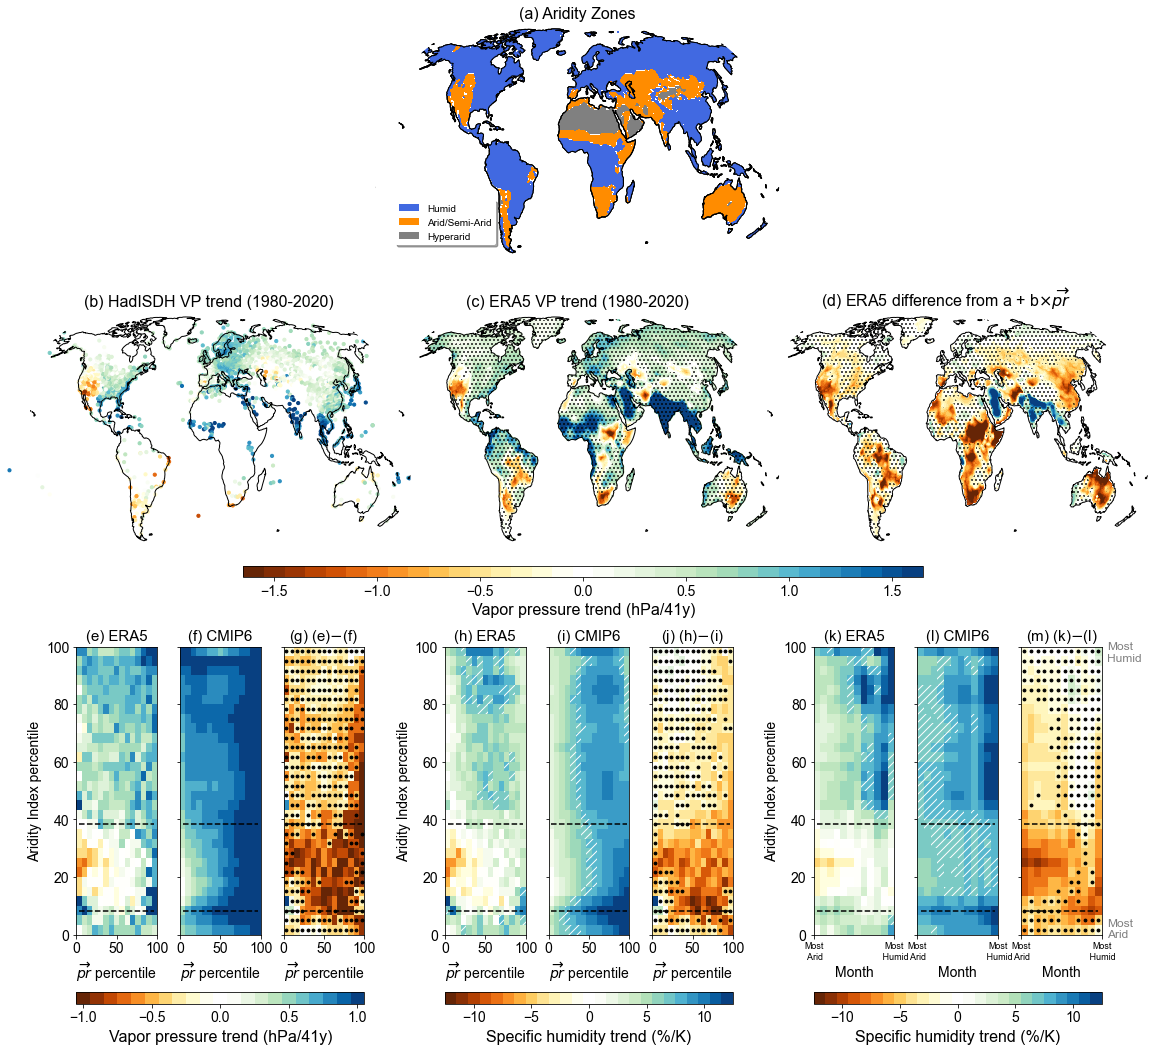

In [20]:
fig = plt.figure(figsize=(16,16))

#---------------------Aridity Zones
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, aridmask, aridmask.lon, aridmask.lat, 0.1, 0, 1, '(a) Aridity Zones',
                                                            0.32,0.67,0.75,0.95, onecolor=True, color='darkorange', fontsize=16)
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, hyperaridmask, hyperaridmask.lon, hyperaridmask.lat,0.1,0,1,' ',
                                                            0.32,0.67,0.75,0.95, onecolor=True, color='gray')
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, humidmask, humidmask.lon, humidmask.lat, 0.1, 0, 1,' ',
                                                            0.32,0.67,0.75,0.95, onecolor=True, color='royalblue')

legendparts = [ Rectangle((0.95,0.95),3,3,facecolor='royalblue'),
                Rectangle((0.95,0.95),3,3,facecolor='darkorange'),
                Rectangle((0.95,0.95),3,3,facecolor='gray')]
legendlabels=['Humid','Arid/Semi-Arid','Hyperarid']
ax.legend(legendparts, legendlabels, bbox_to_anchor=(0.31,0.26), ncol=1,frameon=True, facecolor='white', edgecolor='None',
          framealpha=None, shadow=True)
#----------------------------------


#-------ISD trends globally
#ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, isdmap.vp, np.array(isdmap.lons), np.array(isdmap.lats),0.2,-2,2,'(b) ISD VP trend (1980-2020)',
#                                                                    0.0,0.35,0.5,0.7, cmap='precip', fontsize=16)
ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, hadisdhmap.vp, np.array(hadisdhmap.lon), np.array(hadisdhmap.lat),0.1,-1.6,1.6,'(b) HadISDH VP trend (1980-2020)',
                                                                    0.0,0.35,0.5,0.7, cmap='precip', fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5map.vp*np.array(landfrac), era5map.lon, era5map.lat,0.1,-1.6,1.6,'(c) ERA5 VP trend (1980-2020)',
                                                            0.32,0.67,0.5,0.7, cmap='precip', signifdat=vpshading_era5.vp, stipplesignif=True, fontsize=16)

ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, era5vptrenddif_gpcc*np.array(landfrac), era5map.lon, era5map.lat,0.1,-1.6,1.6,
                                                            '(d) ERA5 difference from a + b$\\times \overrightarrow{pr}$',
                                                            0.64,0.99,0.5,0.7,cmap='precip', signifdat=vpshading_afterp_gpcc, stipplesignif=True, fontsize=16)

ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6,'Vapor pressure trend (hPa/41y)', 0.205,0.795,0.47,0.48,cmap='precip')


#-----VP bin plot
ax = binplot.plot_binned_data_prptile(fig, vp_binned_era5,era5_binned.aridity_ptiles, 0.1,-1,1,'(e) ERA5',0.06,0.13,0.16,0.41, ylabel=True)
fig.text(0.955,0.17,'Most',ha='left',va='center', fontsize=12, color='gray')
fig.text(0.955,0.16,'Arid',ha='left', va='center', fontsize=12, color='gray')
fig.text(0.955,0.41,'Most',ha='left', va='center', fontsize=12, color='gray')
fig.text(0.955,0.40,'Humid',ha='left', va='center', fontsize=12, color='gray')
ax = binplot.plot_binned_data_prptile(fig, vp_binned_cmip6em,era5_binned.aridity_ptiles, 0.1,-1,1,'(f) CMIP6',0.15,0.22,0.16,0.41)
ax = binplot.plot_binned_data_prptile(fig, vp_binned_era5 - vp_binned_cmip6em,era5_binned.aridity_ptiles, 0.1,-1,1,'(g) (e)$-$(f)',
                                      0.24,0.31,0.16,0.41, signifdat=vp_binned_signif)
ax = cbars.plotcolorbar(fig, 0.1, -1, 1,'Vapor pressure trend (hPa/41y)', 0.06,0.31,0.10,0.11,cmap='precip')
#-----------------


#----q bin plot
hatch = q_binned_era5_pcnt_perk.where( (q_binned_era5_pcnt_perk < 6.5) | (q_binned_era5_pcnt_perk > 7.5), nan)
ax = binplot.plot_binned_data_prptile(fig, q_binned_era5_pcnt_perk,era5_binned.aridity_ptiles, 1,-12,12,'(h) ERA5',0.38,0.45,0.16,0.41,ylabel=True, hatching=hatch) 
hatch = q_binned_cmip6_pcnt_perkem.where( (q_binned_cmip6_pcnt_perkem < 6.5) | (q_binned_cmip6_pcnt_perkem > 7.5), nan)
ax = binplot.plot_binned_data_prptile(fig, q_binned_cmip6_pcnt_perkem,era5_binned.aridity_ptiles, 1,-12,12,'(i) CMIP6',0.47,0.54,0.16,0.41, hatching=hatch)
ax = binplot.plot_binned_data_prptile(fig, q_binned_era5_pcnt_perk - q_binned_cmip6_pcnt_perkem,era5_binned.aridity_ptiles, 1, -12, 12,'(j) (h)$-$(i)',
                                      0.56,0.63,0.16,0.41, signifdat=q_pcnt_binned_signif)
ax = cbars.plotcolorbar(fig, 1,-12,12,'Specific humidity trend (%/K)',0.38,0.63,0.1,0.11,cmap='precip')


#----q monthly bin plot
hatch = q_binned_monthly_era5_pcnt_perk.where( (q_binned_monthly_era5_pcnt_perk < 6.5) | (q_binned_monthly_era5_pcnt_perk > 7.5), nan)
ax = binplot.plot_binned_data_monthly(fig, q_binned_monthly_era5_pcnt_perk, obs_binned_monthly.aridity_am, 1, -12, 12,'(k) ERA5',0.7,0.77,0.16,0.41,
                                      ylabel=True, hatching=hatch)

hatch = cmip6_binned_monthly_pcnt_perk_mmm.where( (cmip6_binned_monthly_pcnt_perk_mmm < 6.5) | (cmip6_binned_monthly_pcnt_perk_mmm > 7.5), nan)
ax = binplot.plot_binned_data_monthly(fig, cmip6_binned_monthly_pcnt_perk_mmm, obs_binned_monthly.aridity_am, 1, -12, 12,'(l) CMIP6',
                                      0.79,0.86,0.16,0.41,ylabel=False, hatching=hatch)

ax = binplot.plot_binned_data_monthly(fig, q_binned_monthly_era5_pcnt_perk - cmip6_binned_monthly_pcnt_perk_mmm, obs_binned_monthly.aridity_am, 1, -12, 12,
                                      '(m) (k)$-$(l)',0.88,0.95,0.16,0.41,ylabel=False, signifdat = q_pcnt_binned_monthly_signif )
ax = cbars.plotcolorbar(fig, 1, -12, 12, 'Specific humidity trend (%/K)',0.7,0.95,0.1,0.11,cmap='precip')


fig.savefig(plotpath+'fig3.pdf', bbox_inches='tight', facecolor='white')
